### Libraries


In [1]:
import pandas as pd
import numpy as np
import tqdm as td
from datetime import datetime
from sklearn import preprocessing
from sklearn.decomposition import PCA

### 2. Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

#### 2.1 Getting your data + feature engineering

In [2]:
df = pd.read_csv('bank_transactions.csv')
df.dropna(inplace=True)

In [3]:
USD=df['TransactionAmount (INR)'].apply(lambda x:round(x/81.67,2))
df['TransactionAmount_USD']=USD
USD_2=df['CustAccountBalance'].apply(lambda x:round(x/81.67,2))
df['CustAccountBalance_USD']=USD_2
new_df=df.drop(['TransactionAmount (INR)','CustAccountBalance'],axis=1)
new_df.CustomerDOB = pd.to_datetime(new_df.CustomerDOB) 

In [4]:
new_df.drop(new_df[new_df.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
new_df.TransactionDate=pd.to_datetime(new_df.TransactionDate) 

In [5]:
new_df.TransactionTime = new_df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [6]:
new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']=new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']-pd.DateOffset(years = 100)

In [7]:
new_df['CustomerAge'] = (( pd.to_datetime('today') - new_df.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0).astype(int)
new_df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,TransactionDate,TransactionTime,TransactionAmount_USD,CustAccountBalance_USD,CustomerAge
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,2016-02-08,1900-01-01 14:32:07,0.31,218.18,28
1,T2,C2142763,1957-04-04,M,JHAJJAR,2016-02-08,1900-01-01 14:18:58,342.83,27.80,66
2,T3,C4417068,1996-11-26,F,MUMBAI,2016-02-08,1900-01-01 14:27:12,5.62,218.86,26
3,T4,C5342380,1973-09-14,F,MUMBAI,2016-02-08,1900-01-01 14:27:14,25.22,10609.81,49
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,2016-02-08,1900-01-01 18:11:56,21.58,82.21,35
...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,2016-09-18,1900-01-01 18:48:24,9.78,93.49,32
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,2016-09-18,1900-01-01 18:37:34,5.63,334.41,31
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,2016-09-18,1900-01-01 18:33:13,9.43,2715.28,34
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,2016-09-18,1900-01-01 18:47:06,12.24,123.89,44


In [8]:
dataset=pd.DataFrame()
dataset['CustomerID']=new_df.CustomerID.unique()
dataset=dataset.set_index('CustomerID')

In [9]:
#Number of transactions
new_df.groupby(['CustomerID'],sort=False)['TransactionID'].count()
dataset['Number_Transactions']=new_df.groupby(['CustomerID'],sort=False).count()['TransactionID']

In [10]:
#Number of transactions with a balance bigger than 100 USD
def condition(x):
    if x>100:
        return int(1)
    else:
        return 0

new_df['TransactionAmount_USD>100']=new_df['TransactionAmount_USD'].apply((condition)).to_numpy()
a=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD>100'].sum()
dataset['Transactions>100']=a

In [11]:
# Average amount of the transactions on USD column
new_df.groupby('CustomerID',sort=False).mean()['TransactionAmount_USD']
dataset['AverageAmountTransactions']=new_df.groupby('CustomerID',sort=False).mean()['TransactionAmount_USD'].to_numpy()

In [12]:
#Average balance in USD exchange rate 1 USD = 81,67 INR
new_df.groupby(['CustomerID'],sort=False).mean()['CustAccountBalance_USD']
dataset['AverageBalance']=new_df.groupby(['CustomerID'],sort=False).mean()['CustAccountBalance_USD']

In [13]:
#Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation)
dataset['Utilisation']=dataset.iloc[:,[-1]].to_numpy()-dataset.iloc[:,[-2]].to_numpy()

In [14]:
# Most common gender of the customer
dataset['MostCommonGender']=new_df.groupby('CustomerID',sort=False)['CustGender'].agg(pd.Series.mode)
dataset['MostCommonGender']=dataset.MostCommonGender.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [15]:
# Most frequent location of the customer
dataset['MostCommonLocation']=new_df.groupby('CustomerID',sort=False)['CustLocation'].agg((pd.Series.mode))
dataset['MostCommonLocation']=dataset.MostCommonLocation.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [16]:
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation
CustomerID,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI
...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI


Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. 
<br> Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

In [17]:
dataset['MaxTransaction']=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].max()
dataset['MinTransaction']=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].min()

In [18]:
dataset['25thPercentileTransaction'] = round(new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].quantile(q=0.25),2)
dataset['75thPercentileTransaction'] = round(new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].quantile(q=0.75),2)
# Median of transactions for each customer
dataset['MedianTransactions']=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].median()

In [19]:
## max/min balance owned by a customer
dataset['MaxBalance']=new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].max()
dataset['MinBalance']=new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].min()

In [20]:
# 25th, 75th, median percentile of balance for each customer
dataset['25thPercentileBalance'] = round(new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].quantile(q=0.25),2)
dataset['75thPercentileBalance'] = round(new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].quantile(q=0.75),2)
dataset['MedianBalance']=new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].median()
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,MaxTransaction,MinTransaction,25thPercentileTransaction,75thPercentileTransaction,MedianTransactions,MaxBalance,MinBalance,25thPercentileBalance,75thPercentileBalance,MedianBalance
CustomerID,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,0.31,0.31,0.31,0.31,0.31,218.18,218.18,218.18,218.18,218.18
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR,342.83,342.83,342.83,342.83,342.83,27.80,27.80,27.80,27.80,27.80
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,5.62,5.62,5.62,5.62,5.62,218.86,218.86,218.86,218.86,218.86
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,25.22,10.76,14.38,21.60,17.99,10609.81,39.13,2681.80,7967.14,5324.47
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,21.58,21.58,21.58,21.58,21.58,82.21,82.21,82.21,82.21,82.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE,36.73,36.73,36.73,36.73,36.73,5.69,5.69,5.69,5.69,5.69
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE,18.37,18.37,18.37,18.37,18.37,14.85,14.85,14.85,14.85,14.85
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,9.78,9.78,9.78,9.78,9.78,93.49,93.49,93.49,93.49,93.49


In [21]:
## Number of transactions where the amount was less than 10 % of their balance
def condition_(x,y):
    if x<0.1*y:
        return 1
    else:
        return 0
l=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    l.append(condition_(i,j))
new_df['transaction<10%balance']=l
dataset['Transaction<10%Balance']=new_df.groupby('CustomerID',sort=False)['transaction<10%balance'].sum()

In [22]:
# Number of transactions where the amount was greater than 50 % of their balance
def condition_50(x,y):
    if x>0.5*y:
        return 1
    else:
        return 0
transactions=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    transactions.append(condition_50(i,j))
new_df['transaction>50%balance']=transactions
dataset['Transaction>50%Balance']=new_df.groupby('CustomerID',sort=False)['transaction>50%balance'].sum()
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,MaxTransaction,MinTransaction,25thPercentileTransaction,75thPercentileTransaction,MedianTransactions,MaxBalance,MinBalance,25thPercentileBalance,75thPercentileBalance,MedianBalance,Transaction<10%Balance,Transaction>50%Balance
CustomerID,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,0.31,0.31,0.31,0.31,0.31,218.18,218.18,218.18,218.18,218.18,1,0
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR,342.83,342.83,342.83,342.83,342.83,27.80,27.80,27.80,27.80,27.80,0,1
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,5.62,5.62,5.62,5.62,5.62,218.86,218.86,218.86,218.86,218.86,1,0
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,25.22,10.76,14.38,21.60,17.99,10609.81,39.13,2681.80,7967.14,5324.47,1,0
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,21.58,21.58,21.58,21.58,21.58,82.21,82.21,82.21,82.21,82.21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE,36.73,36.73,36.73,36.73,36.73,5.69,5.69,5.69,5.69,5.69,0,1
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE,18.37,18.37,18.37,18.37,18.37,14.85,14.85,14.85,14.85,14.85,0,1
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,9.78,9.78,9.78,9.78,9.78,93.49,93.49,93.49,93.49,93.49,0,0


In [23]:
## Transactions greater than Customer's account balance
rule_red=(lambda x,y : 1 if x>y else 0 )
red=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    red.append(rule_red(i,j))
new_df['RedAccount']=red
dataset['NumberTransactions>Balance'] = new_df.groupby('CustomerID',sort=False)['RedAccount'].sum()

In [24]:
## Number of transactions > 20h to be completed
def time_condition(x):
    if x>=20:
        return 1
    else:
        return 0
new_df['transactionsTime>20h'] = new_df.TransactionTime.dt.hour.apply(time_condition)
dataset['NumberTransactions>=20h'] = new_df.groupby('CustomerID',sort=False)['transactionsTime>20h'].sum()

In [25]:
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,MaxTransaction,MinTransaction,25thPercentileTransaction,...,MedianTransactions,MaxBalance,MinBalance,25thPercentileBalance,75thPercentileBalance,MedianBalance,Transaction<10%Balance,Transaction>50%Balance,NumberTransactions>Balance,NumberTransactions>=20h
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,0.31,0.31,0.31,...,0.31,218.18,218.18,218.18,218.18,218.18,1,0,0,0
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR,342.83,342.83,342.83,...,342.83,27.80,27.80,27.80,27.80,27.80,0,1,1,0
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,5.62,5.62,5.62,...,5.62,218.86,218.86,218.86,218.86,218.86,1,0,0,0
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,25.22,10.76,14.38,...,17.99,10609.81,39.13,2681.80,7967.14,5324.47,1,0,0,0
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,21.58,21.58,21.58,...,21.58,82.21,82.21,82.21,82.21,82.21,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE,36.73,36.73,36.73,...,36.73,5.69,5.69,5.69,5.69,5.69,0,1,1,0
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE,18.37,18.37,18.37,...,18.37,14.85,14.85,14.85,14.85,14.85,0,1,1,0
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,9.78,9.78,9.78,...,9.78,93.49,93.49,93.49,93.49,93.49,0,0,0,0


In [26]:
# Customer birthday
dataset['CustomersAge'] = new_df.groupby('CustomerID',sort=False).CustomerAge.agg(pd.Series.mode)
dataset['CustomersAge']=dataset.CustomersAge.apply(lambda x: x[0] if isinstance(x,np.ndarray) else x)

In [27]:
## Number of users which used the bank account, we can get this from the different CustomerDOB recorded for the same CustomerID
dataset['NumberUsers'] = new_df.groupby('CustomerID',sort=False)['CustomerDOB'].nunique()

In [28]:
l=['MostCommonLocation','MostCommonGender','CustomersAge']
for i in l:
    li=[]
    for j in (dataset[i]):
        if isinstance(j,np.ndarray):
            li.append(list(j))
        else:
            li.append(j)
    dataset[i]=li
        

In [29]:
l=['AverageAmountTransactions','AverageBalance','Utilisation','MedianTransactions','MedianBalance']
for i in l:
    dataset[i]=dataset[i].apply(lambda x: round(x,2))

In [30]:
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,MaxTransaction,MinTransaction,25thPercentileTransaction,...,MinBalance,25thPercentileBalance,75thPercentileBalance,MedianBalance,Transaction<10%Balance,Transaction>50%Balance,NumberTransactions>Balance,NumberTransactions>=20h,CustomersAge,NumberUsers
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,0.31,0.31,0.31,...,218.18,218.18,218.18,218.18,1,0,0,0,28,1
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR,342.83,342.83,342.83,...,27.80,27.80,27.80,27.80,0,1,1,0,66,1
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,5.62,5.62,5.62,...,218.86,218.86,218.86,218.86,1,0,0,0,26,1
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,25.22,10.76,14.38,...,39.13,2681.80,7967.14,5324.47,1,0,0,0,44,2
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,21.58,21.58,21.58,...,82.21,82.21,82.21,82.21,0,0,0,0,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE,36.73,36.73,36.73,...,5.69,5.69,5.69,5.69,0,1,1,0,43,1
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE,18.37,18.37,18.37,...,14.85,14.85,14.85,14.85,0,1,1,0,30,1
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,9.78,9.78,9.78,...,93.49,93.49,93.49,93.49,0,0,0,0,32,1


In [256]:
## Assuming that age of majority in India is 18 years, we can retrieve the number of transactions done by not legally adult people
rule_18=(lambda x:1 if x<23 else 0)
new_df.loc[new_df.CustomerAge.apply(rule_18)==1]


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,TransactionDate,TransactionTime,TransactionAmount_USD,CustAccountBalance_USD,CustomerAge,TransactionAmount_USD>100,transaction<10%balance,transaction>50%balance,transactionsTime>20h,RedAccount
6966,T6967,C1911373,2000-11-04,M,PEN,2016-09-25,1900-01-01 13:48:02,0.73,32.91,22,0,1,0,0,0
7677,T7678,C1441125,2000-09-15,M,MUMBAI,2016-09-27,1900-01-01 18:19:54,15.00,68.10,22,0,0,0,0,0
8090,T8091,C5842760,2000-12-09,M,NAVI MUMBAI,2016-09-25,1900-01-01 20:06:43,7.59,127.91,22,0,1,0,1,0
12080,T12081,C1528417,2000-08-01,F,VIZIANAGARAM,2016-09-26,1900-01-01 22:14:02,2.72,20.92,22,0,0,0,1,0
13821,T13822,C2110112,2000-12-01,M,SRINAGAR,2016-09-22,1900-01-01 12:17:20,1.22,304.90,22,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025174,T1025175,C7840585,2000-07-02,M,PUNE,2016-09-13,1900-01-01 16:05:58,12.24,436.55,22,0,1,0,0,0
1028878,T1028879,C5315956,2000-11-16,F,MUMBAI,2016-09-13,1900-01-01 17:19:36,2.33,1.54,22,0,0,1,0,1
1033054,T1033055,C5121063,2000-09-09,M,AGRA,2016-09-18,1900-01-01 16:36:37,10.03,136.99,22,0,1,0,0,0
1035639,T1035640,C9022891,2000-09-18,M,NEW DELHI,2016-09-18,1900-01-01 17:12:29,6.12,5065.27,22,0,1,0,0,0


#### 2.2 Choose your features (variables)!

We have plenty of features to work with now. So, we need to find a way to reduce the dimensionality (reduce the number of variables to work with). 
<br>We follow the subquent steps.

In [364]:
import pyspark
from sklearn.decomposition import KernelPCA

In [31]:
from sklearn.cluster import KMeans

In [32]:
preprocessing.StandardScaler().fit_transform(dataset[['AverageAmountTransactions','AverageBalance']].head(10).to_numpy())

array([[-0.40881364, -0.38266394],
       [ 2.9934472 , -0.50615142],
       [-0.35606926, -0.38222287],
       [-0.2331977 ,  2.92946378],
       [-0.19753813, -0.47085909],
       [-0.32964741, -0.09841183],
       [-0.38696098, -0.42409238],
       [-0.3939141 ,  0.23092055],
       [-0.310576  , -0.40578785],
       [-0.37672996, -0.49019495]])

In [33]:
d=dataset.drop(['MostCommonGender','MostCommonLocation'],inplace=False,axis=1)
d

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MaxTransaction,MinTransaction,25thPercentileTransaction,75thPercentileTransaction,MedianTransactions,...,MinBalance,25thPercentileBalance,75thPercentileBalance,MedianBalance,Transaction<10%Balance,Transaction>50%Balance,NumberTransactions>Balance,NumberTransactions>=20h,CustomersAge,NumberUsers
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,0.31,0.31,0.31,0.31,0.31,...,218.18,218.18,218.18,218.18,1,0,0,0,28,1
C2142763,1,1,342.83,27.80,-315.03,342.83,342.83,342.83,342.83,342.83,...,27.80,27.80,27.80,27.80,0,1,1,0,66,1
C4417068,1,0,5.62,218.86,213.24,5.62,5.62,5.62,5.62,5.62,...,218.86,218.86,218.86,218.86,1,0,0,0,26,1
C5342380,2,0,17.99,5324.47,5306.48,25.22,10.76,14.38,21.60,17.99,...,39.13,2681.80,7967.14,5324.47,1,0,0,0,44,2
C9031234,1,0,21.58,82.21,60.63,21.58,21.58,21.58,21.58,21.58,...,82.21,82.21,82.21,82.21,0,0,0,0,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,36.73,36.73,36.73,36.73,36.73,...,5.69,5.69,5.69,5.69,0,1,1,0,43,1
C1034220,1,0,18.37,14.85,-3.52,18.37,18.37,18.37,18.37,18.37,...,14.85,14.85,14.85,14.85,0,1,1,0,30,1
C8020229,1,0,9.78,93.49,83.71,9.78,9.78,9.78,9.78,9.78,...,93.49,93.49,93.49,93.49,0,0,0,0,32,1


In [37]:
for i in d.columns:
    col=d[i]
    min_=col.min()
    max_=d[i].max()
    fun=(lambda x : (x-min_)/(max_-min_))
    d[i]=d[i].apply(fun)
d_norm=d

In [433]:
d_normalized=pd.DataFrame(preprocessing.normalize(d,norm='l1'),index=d.index,columns=d.columns)
d_normalized

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MaxTransaction,MinTransaction,25thPercentileTransaction,75thPercentileTransaction,MedianTransactions,...,MinBalance,25thPercentileBalance,75thPercentileBalance,MedianBalance,Transaction<10%Balance,Transaction>50%Balance,NumberTransactions>Balance,NumberTransactions>=20h,NumberUsers,CustomersAge
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,0.0,0.0,0.000016,0.000155,0.013173,0.000016,0.000016,0.000016,0.000016,0.000016,...,0.000155,0.000155,0.000155,0.000155,0.2,0.000000,0.000000,0.0,0.0,0.06
C2142763,0.0,0.5,0.017948,0.000020,0.012800,0.017948,0.017948,0.017948,0.017948,0.017948,...,0.000020,0.000020,0.000020,0.000020,0.0,0.333333,0.333333,0.0,0.0,0.44
C4417068,0.0,0.0,0.000294,0.000155,0.013170,0.000294,0.000294,0.000294,0.000294,0.000294,...,0.000155,0.000155,0.000155,0.000155,0.2,0.000000,0.000000,0.0,0.0,0.04
C5342380,0.2,0.0,0.000942,0.003780,0.016739,0.001320,0.000563,0.000753,0.001131,0.000942,...,0.000028,0.001904,0.005656,0.003780,0.2,0.000000,0.000000,0.0,0.2,0.22
C9031234,0.0,0.0,0.001130,0.000058,0.013063,0.001130,0.001130,0.001130,0.001130,0.001130,...,0.000058,0.000058,0.000058,0.000058,0.0,0.000000,0.000000,0.0,0.0,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,0.0,0.0,0.001923,0.000004,0.012999,0.001923,0.001923,0.001923,0.001923,0.001923,...,0.000004,0.000004,0.000004,0.000004,0.0,0.333333,0.333333,0.0,0.0,0.21
C1034220,0.0,0.0,0.000962,0.000011,0.013018,0.000962,0.000962,0.000962,0.000962,0.000962,...,0.000011,0.000011,0.000011,0.000011,0.0,0.333333,0.333333,0.0,0.0,0.08
C8020229,0.0,0.0,0.000512,0.000066,0.013079,0.000512,0.000512,0.000512,0.000512,0.000512,...,0.000066,0.000066,0.000066,0.000066,0.0,0.000000,0.000000,0.0,0.0,0.10


In [38]:
pca=PCA().fit(d_norm)
pca_features=pca.transform(d_norm)

In [39]:
data=pd.DataFrame(pca_features,columns=['PC%s' % _ for _ in range(1,22)])
data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-0.062256,-0.061674,0.054660,-0.065959,-0.068478,-0.033859,0.004471,-0.000455,-0.000583,-9.918956e-05,...,0.000061,0.000016,0.000009,5.016407e-07,0.000002,2.244829e-07,1.546982e-07,-7.738933e-09,4.456615e-09,4.668833e-13
1,0.484164,-0.035291,0.068751,0.524648,0.003534,-0.089170,-0.037111,-0.011994,0.011669,-3.674469e-04,...,-0.002826,-0.000028,0.000099,7.971518e-06,-0.000005,-1.518861e-07,-9.064715e-07,-1.659335e-08,-9.713150e-08,-7.866198e-12
2,-0.062004,-0.058648,0.055350,-0.077426,-0.084390,-0.036131,0.004682,0.000038,0.000208,-8.386992e-05,...,0.000043,0.000018,0.000011,4.715770e-07,0.000002,2.387198e-07,1.706810e-07,-8.378921e-09,5.362297e-09,1.547632e-13
3,-0.088573,0.121384,0.136427,0.049359,0.061282,0.146583,-0.041055,0.006833,0.000380,-3.547204e-04,...,-0.000474,-0.000485,-0.000024,8.346567e-07,-0.000006,-1.628595e-06,-1.021228e-06,1.125776e-07,-7.020660e-08,1.269888e-11
4,0.032521,-0.154880,0.002127,-0.027149,-0.048156,0.110479,-0.037031,0.000502,0.000628,5.808791e-04,...,0.000001,0.000017,0.000014,-3.432124e-07,0.000002,1.762371e-07,1.170234e-07,-2.913378e-08,1.045489e-08,8.438552e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,0.439049,-0.018586,0.054166,-0.013528,0.097681,-0.032952,-0.030374,-0.001550,0.001998,-1.021114e-04,...,-0.000021,0.000011,0.000009,2.356342e-07,0.000002,2.029281e-07,1.745851e-07,-1.918962e-08,1.828346e-08,-9.534234e-12
839077,0.440630,0.001090,0.058649,-0.088395,-0.005563,-0.047690,-0.028999,0.001547,0.000375,-2.225237e-07,...,-0.000033,0.000019,0.000011,1.101378e-06,0.000002,3.014932e-07,1.932720e-07,-2.803749e-08,1.498910e-08,-1.184969e-11
839078,0.032878,-0.150339,0.003161,-0.044473,-0.071954,0.107082,-0.036713,0.001218,-0.000715,6.047369e-04,...,0.000013,0.000019,0.000014,8.329844e-09,0.000002,1.998559e-07,1.091471e-07,-3.184667e-08,8.381271e-09,2.682490e-13
839079,-0.062621,-0.066215,0.053626,-0.048670,-0.044653,-0.030462,0.004154,-0.000945,-0.000074,-1.225498e-04,...,0.000062,0.000015,0.000008,2.797048e-07,0.000002,2.017689e-07,1.521078e-07,-5.608439e-09,5.403173e-09,1.003372e-12


In [40]:
np.sum(pca.explained_variance_ratio_[0:4]) # the first three PCA features retain more than 70 % of total variance

0.8549916094803722

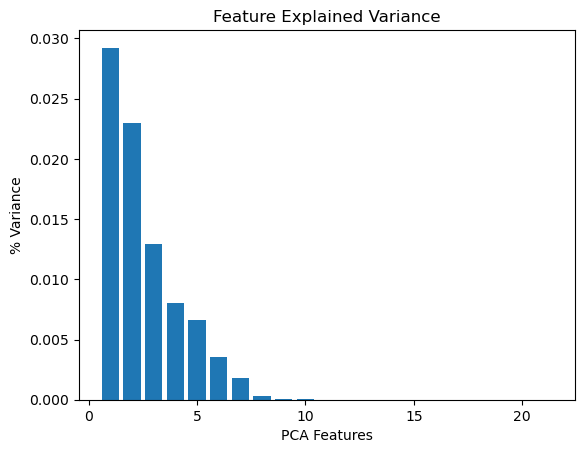

In [41]:
import matplotlib.pyplot as plt
plt.bar(
    range(1,len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Features')
plt.ylabel('% Variance')
plt.title('Feature Explained Variance')
plt.show()

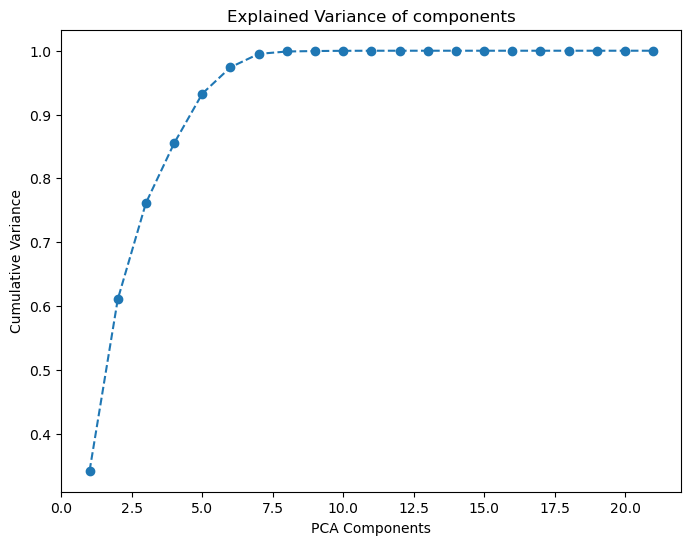

In [42]:
plt.figure(figsize=(8,6))
plt.plot(range(1,22),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')

plt.title('Explained Variance of components')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Variance')
plt.show()

Text(0, 0.5, 'PCA 2')

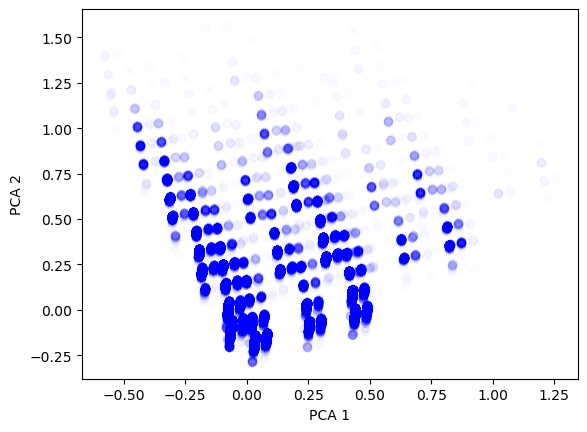

In [49]:
plt.scatter(data.iloc[:,0], data.iloc[:,1], alpha=0.01, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [50]:
pca=PCA(n_components=3)
pca.fit(d_norm)
pca_features=pca.transform(d_norm)

In [51]:
wcss=[]
for i in range(1,22):
    k=KMeans(n_clusters=i,init='k-means++',random_state=40)
    k.fit(pca_features)
    wcss.append(k.inertia_)

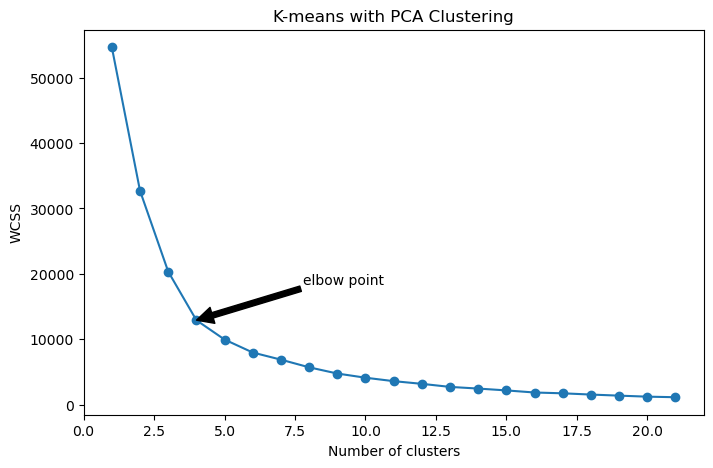

In [52]:
plt.figure(figsize=(8,5))
plt.plot(range(1,22),wcss,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.annotate('elbow point',(4,wcss[3]),arrowprops=dict(facecolor='black',shrink=0.001),
            horizontalalignment='left',verticalalignment='top',xytext=(7.8,20000))
plt.show()

In [57]:
k=KMeans(n_clusters=3,init='random',random_state=42)
k=k.fit(data)


In [58]:
df_kmeans=pd.concat([d.reset_index(drop=True),pd.DataFrame(pca_features)],axis=1)
df_kmeans['Clusters']=k.labels_

In [59]:
df_kmeans['Segment']=df_kmeans['Clusters'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth',5:'sixth',6:'seventh',7:'eighth'})

C:\Users\matti\AppData\Local\Temp\ipykernel_16088\3895309830.py:7: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(x=x,y=y,hue=df_kmeans['Segment'],palette=sns.color_palette('hls',4))


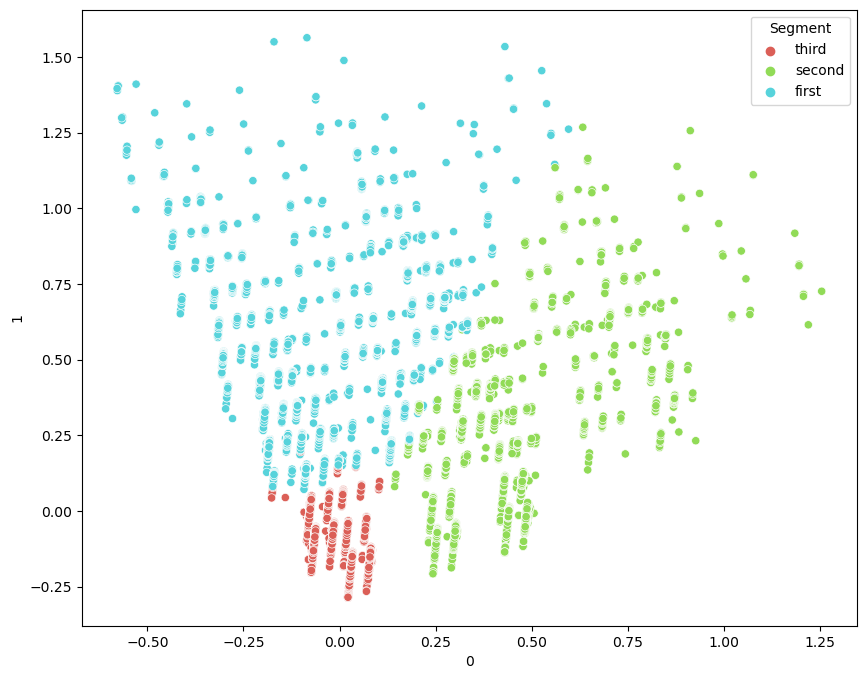

In [60]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

x=df_kmeans[0]
y=df_kmeans[1]
plt.figure(figsize=(10,8))
sns.scatterplot(x=x,y=y,hue=df_kmeans['Segment'],palette=sns.color_palette('hls',4))
plt.show()

In [68]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)


def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KMeans:
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break

            if self.plot_steps:
                self.plot()

        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)

    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [
            euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)
        ]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=20)

        plt.show()


3


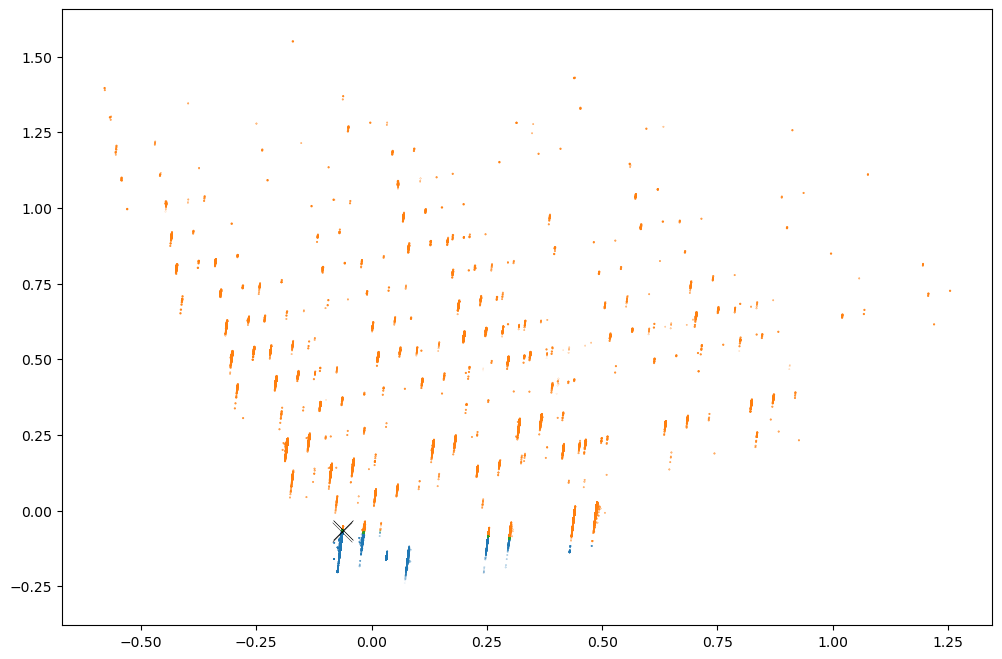

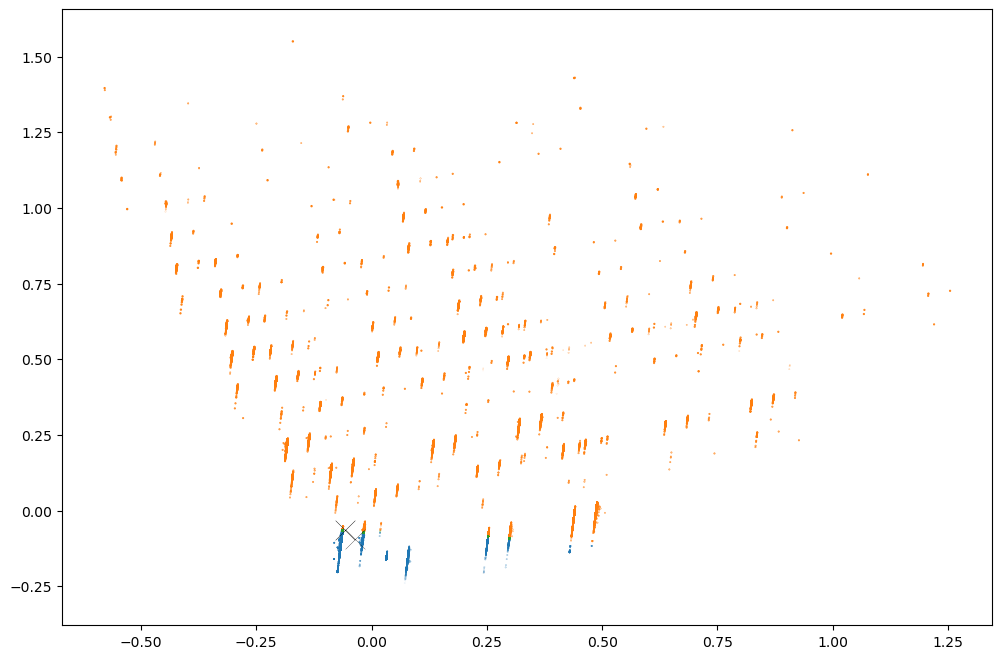

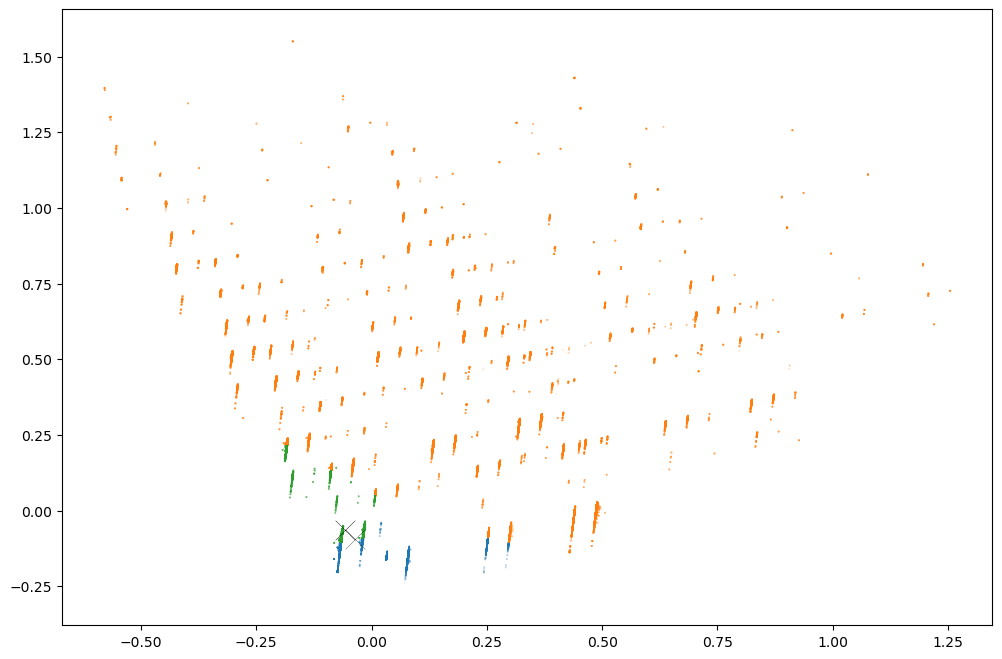

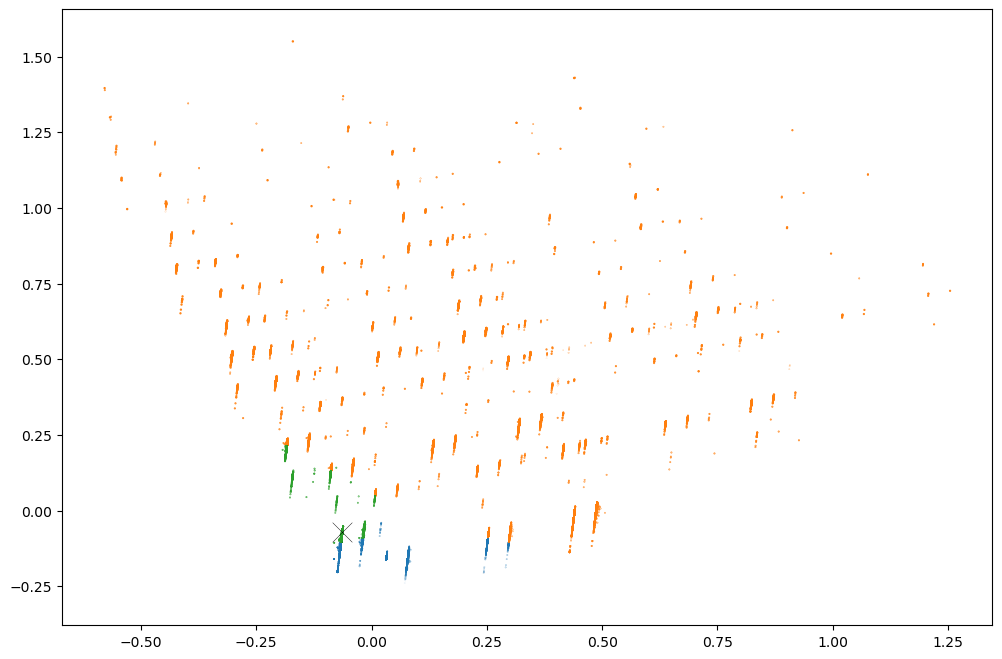

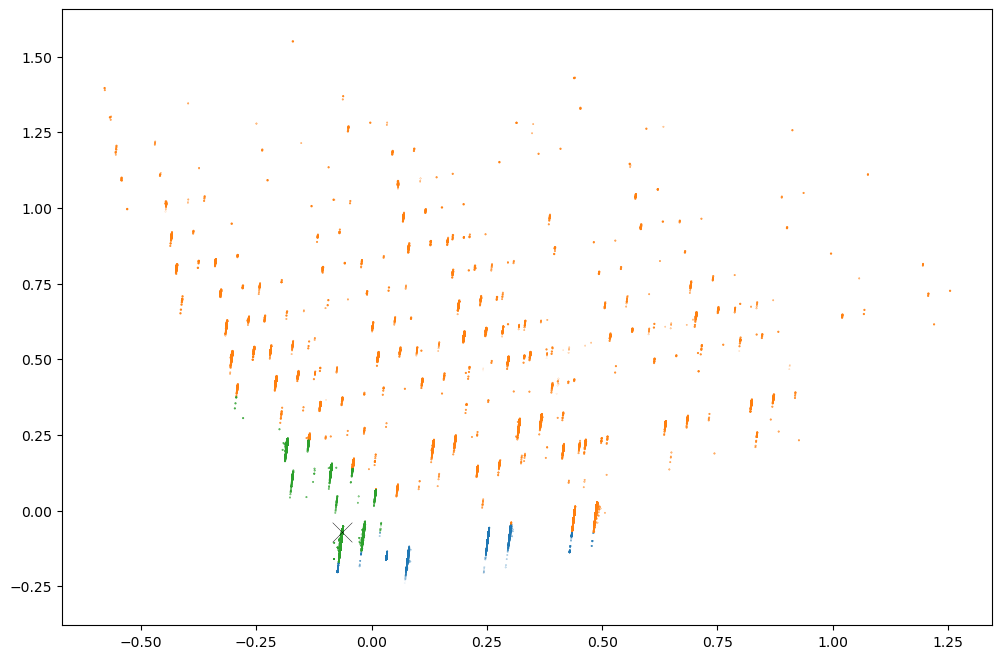

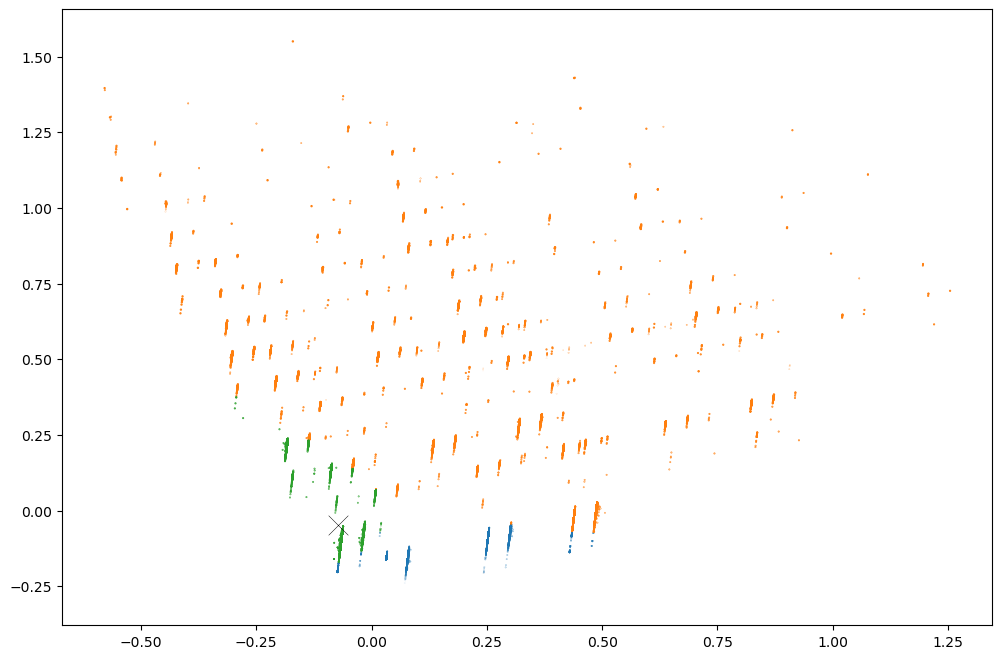

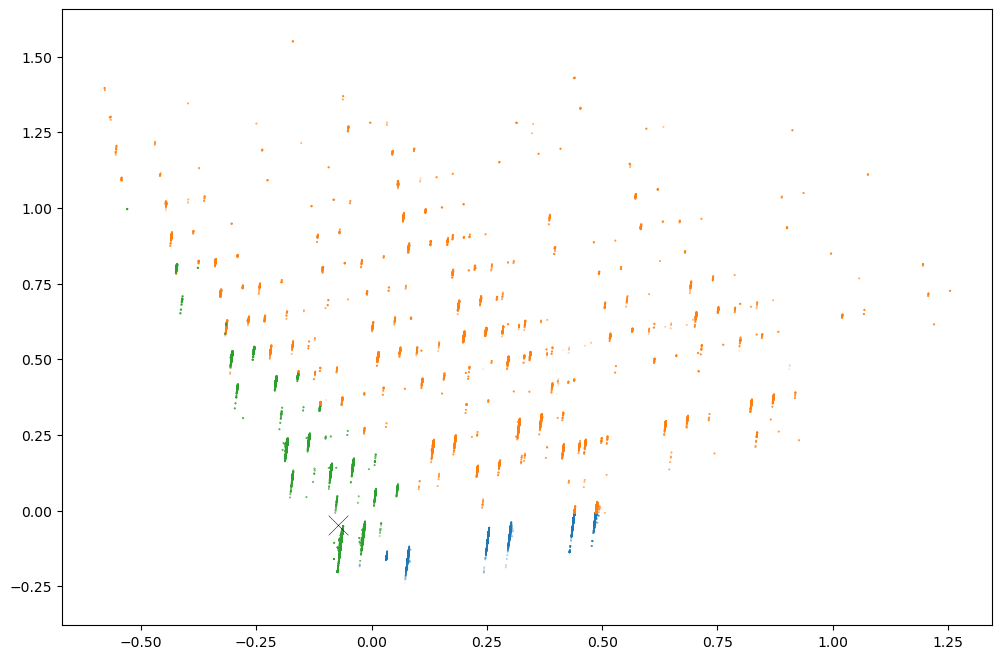

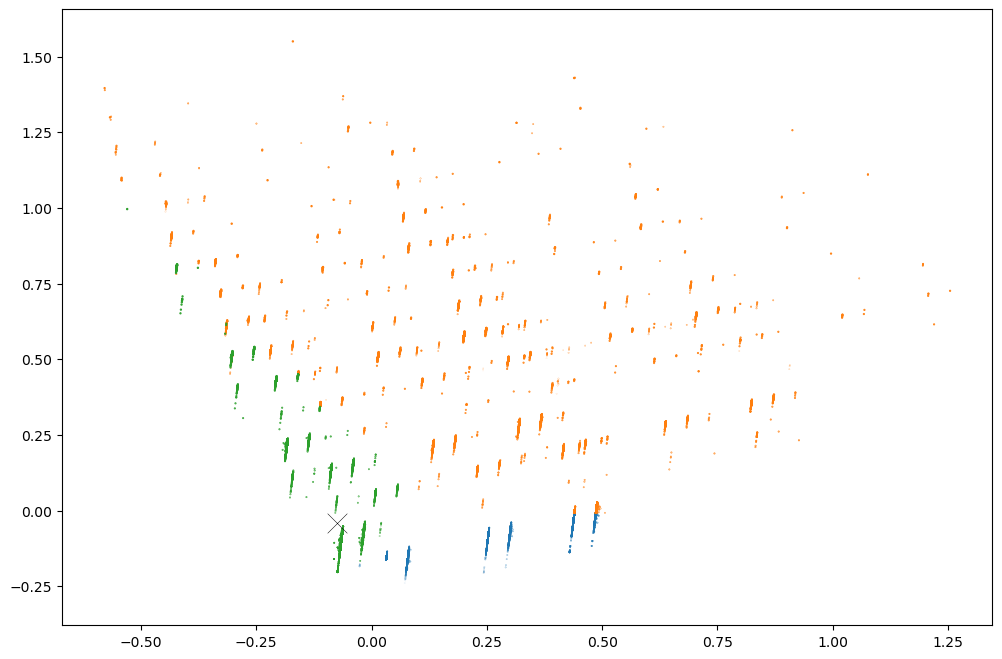

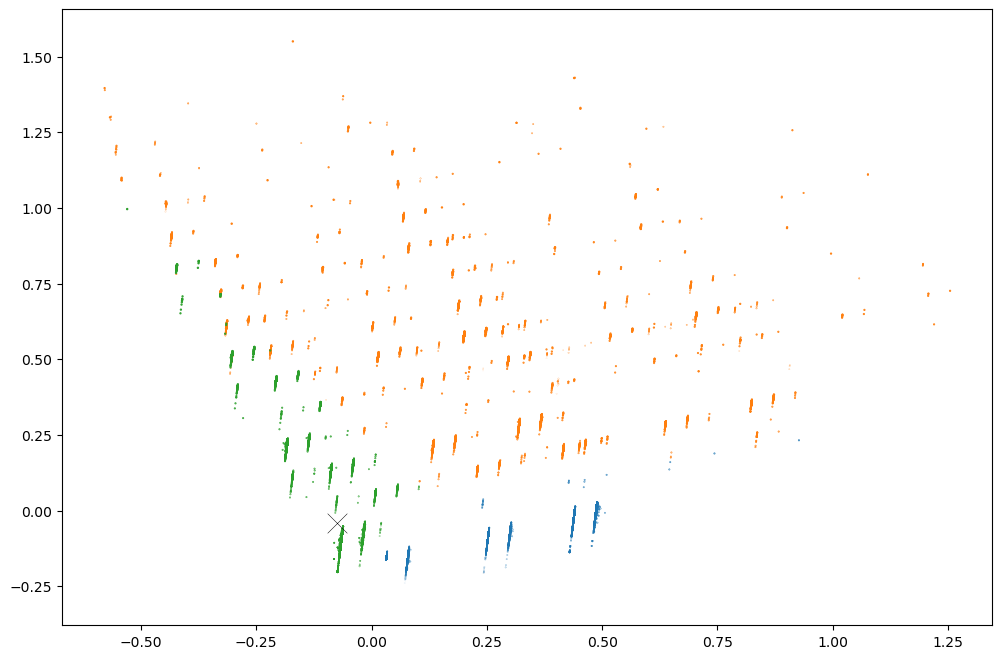

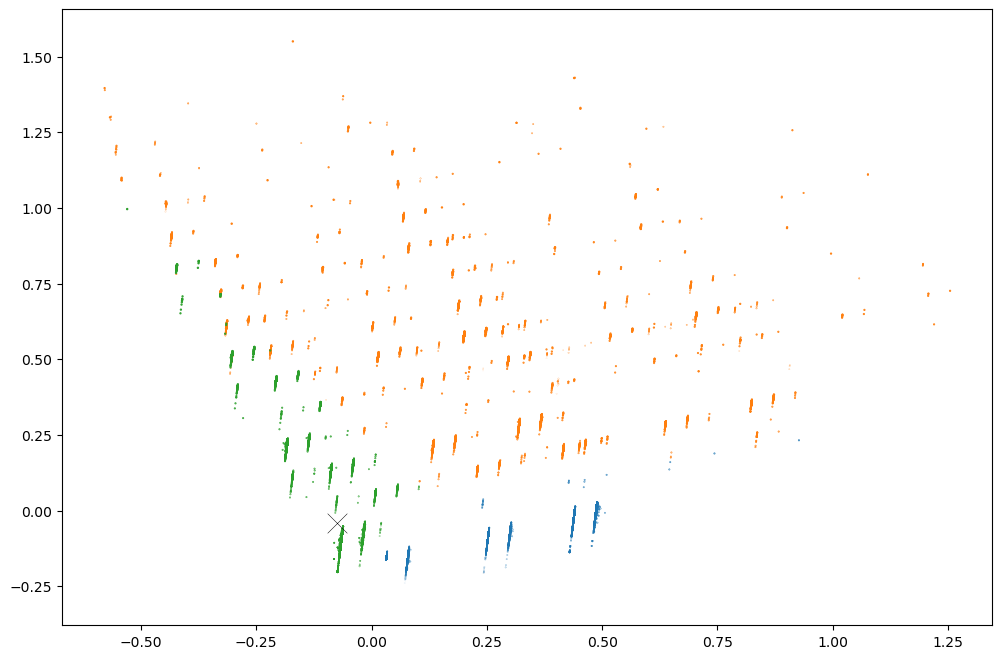

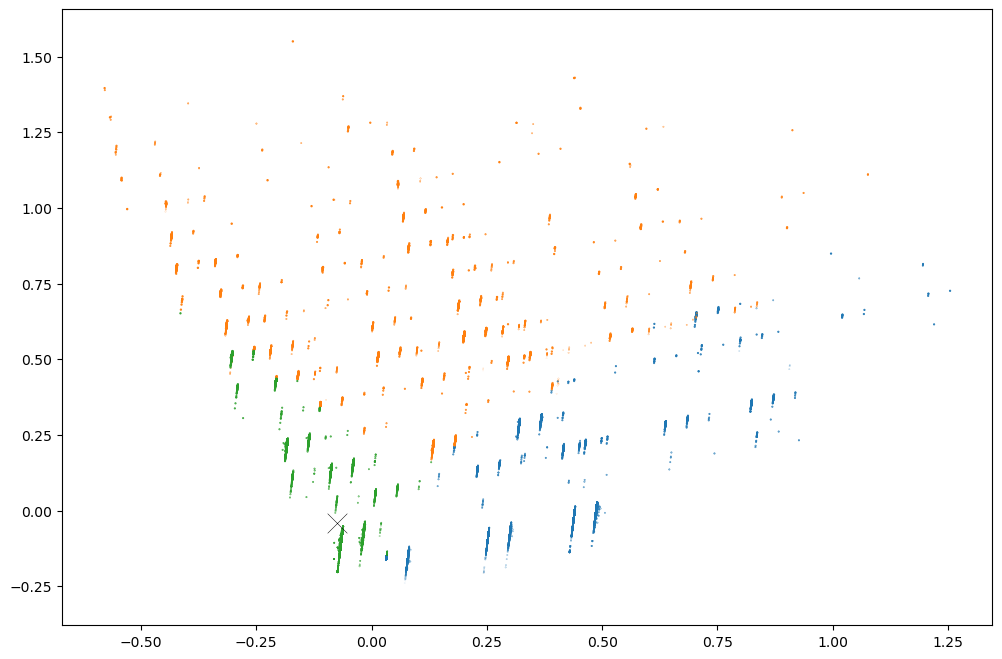

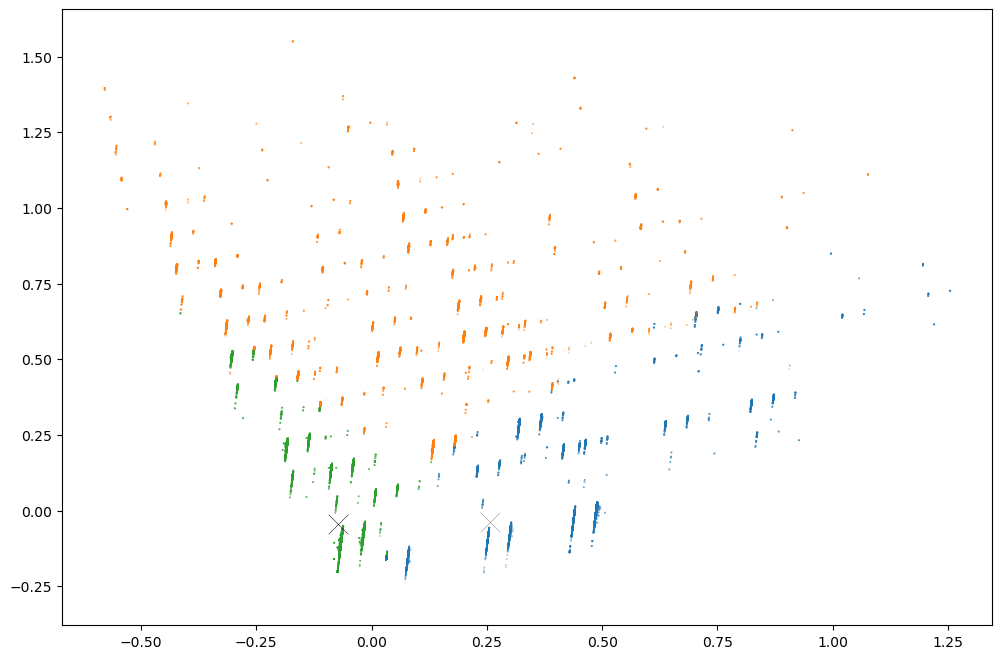

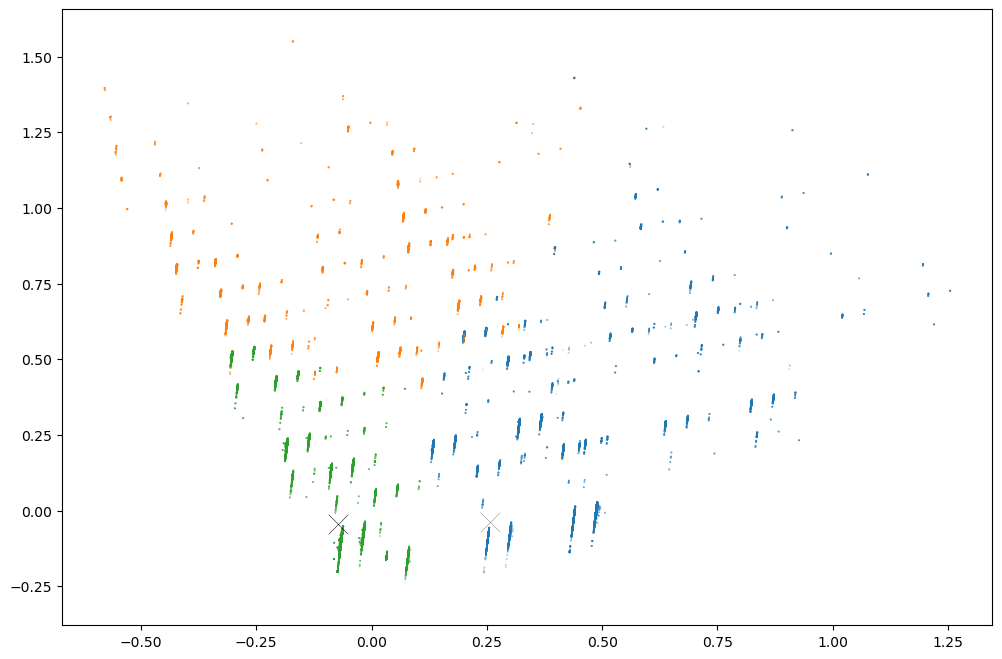

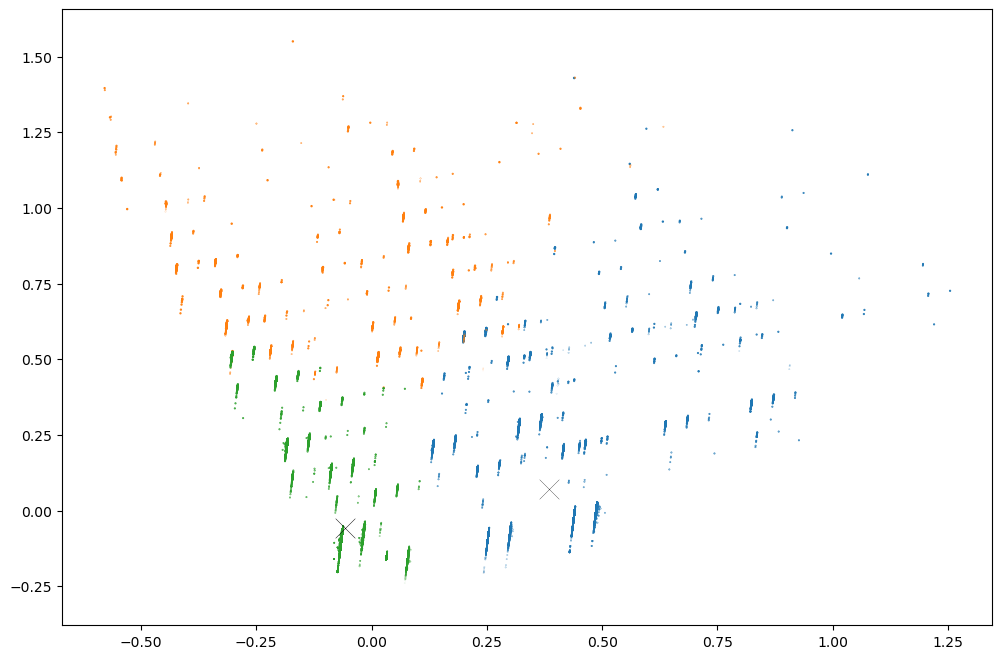

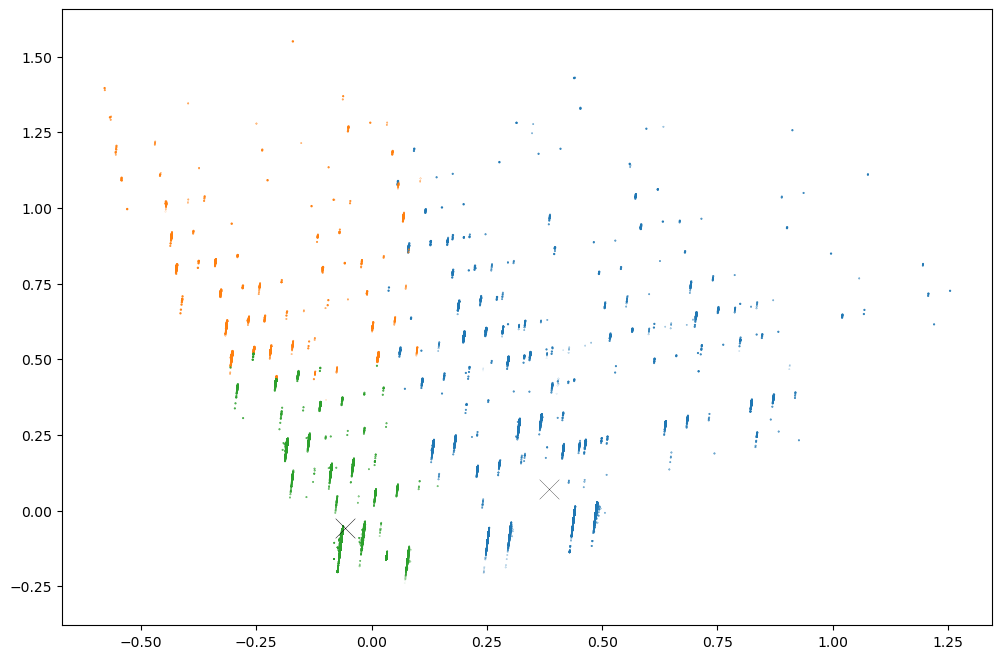

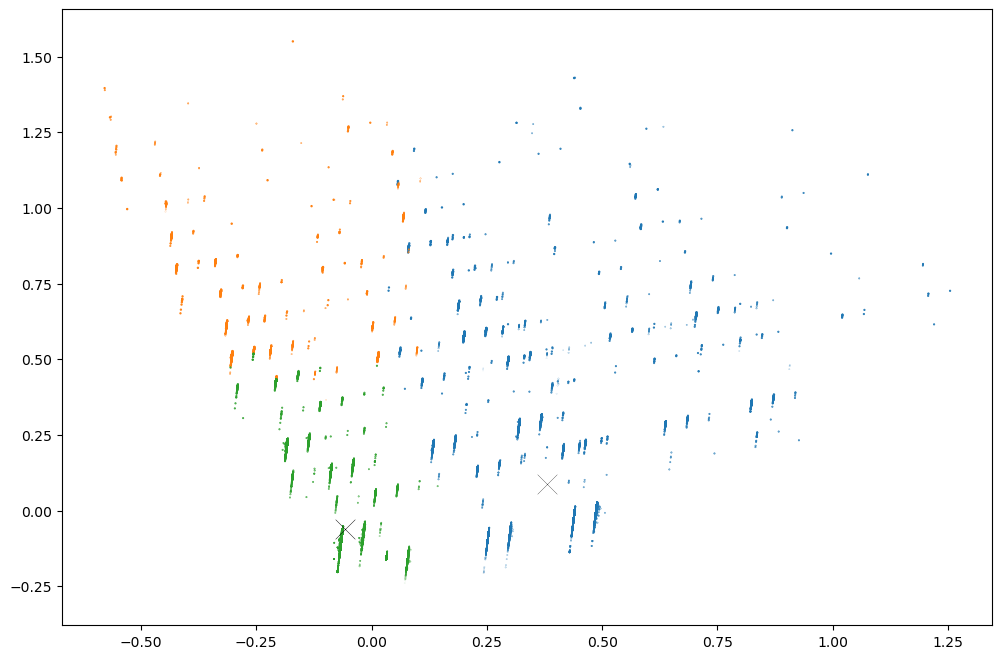

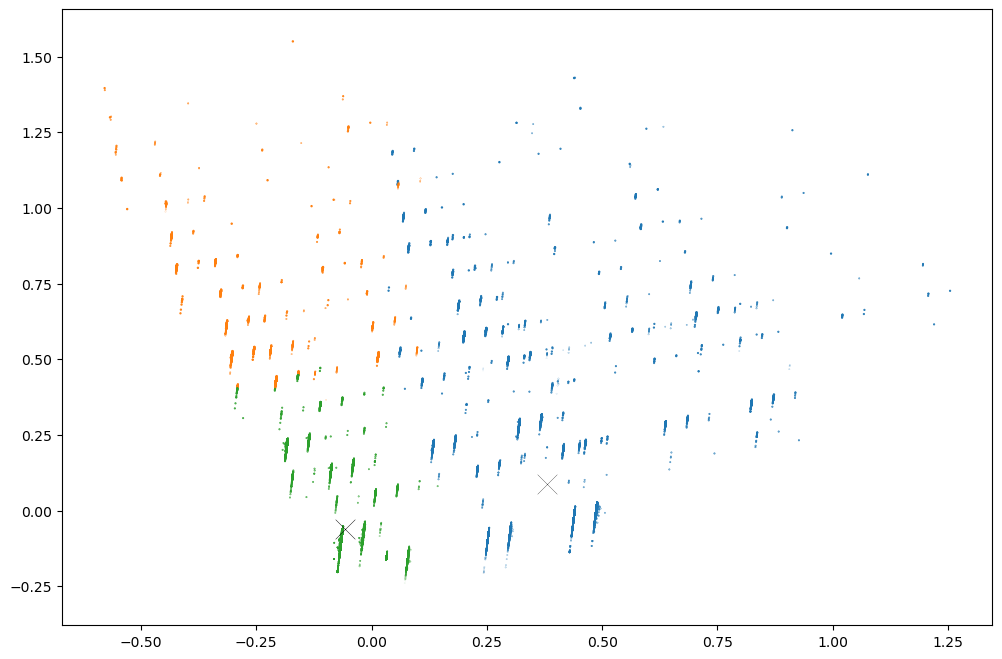

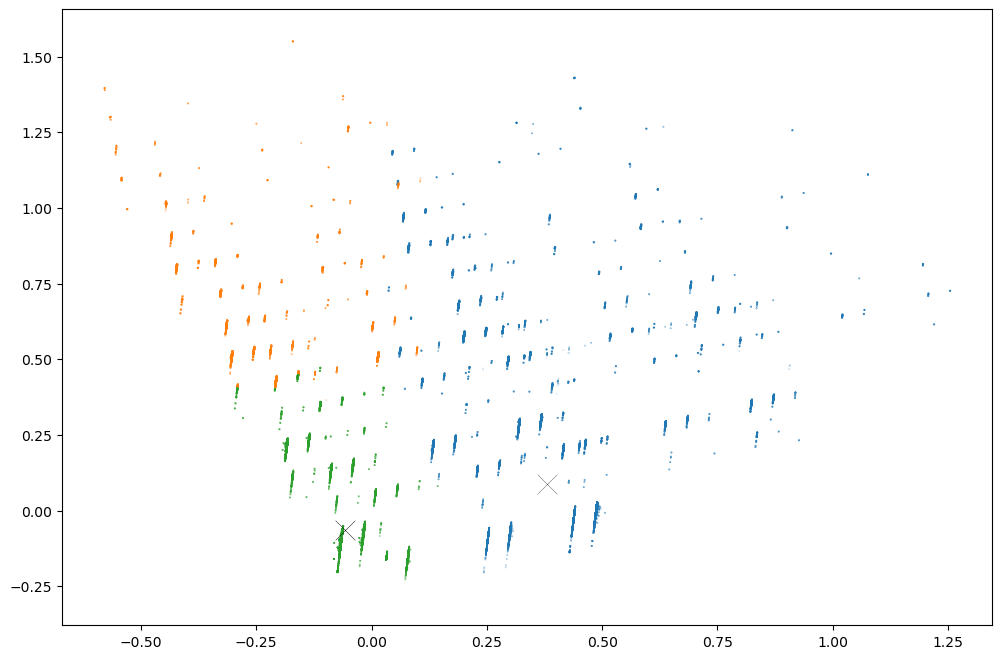

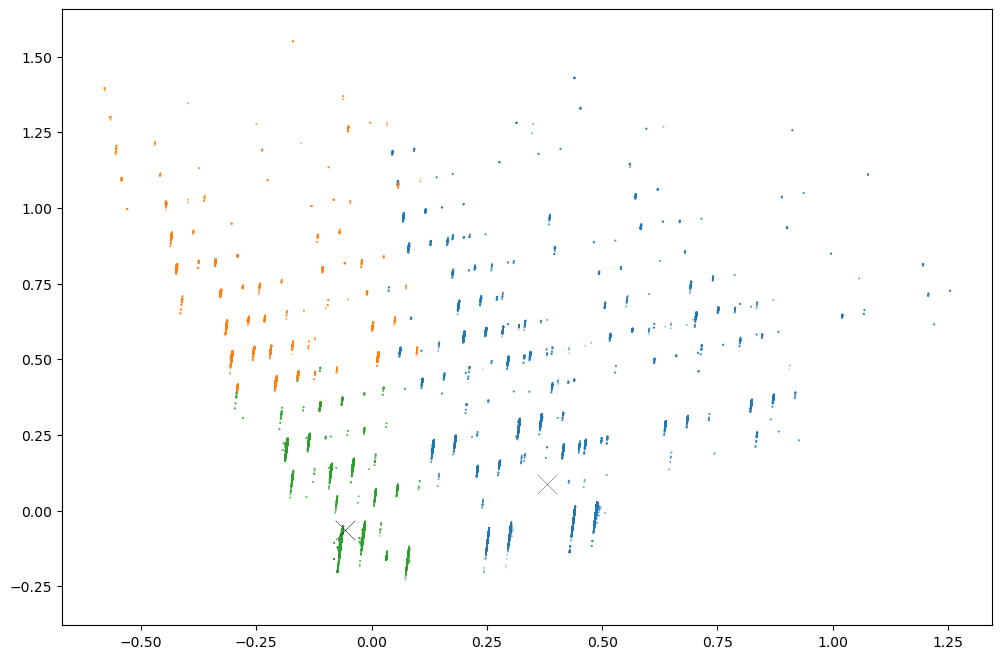

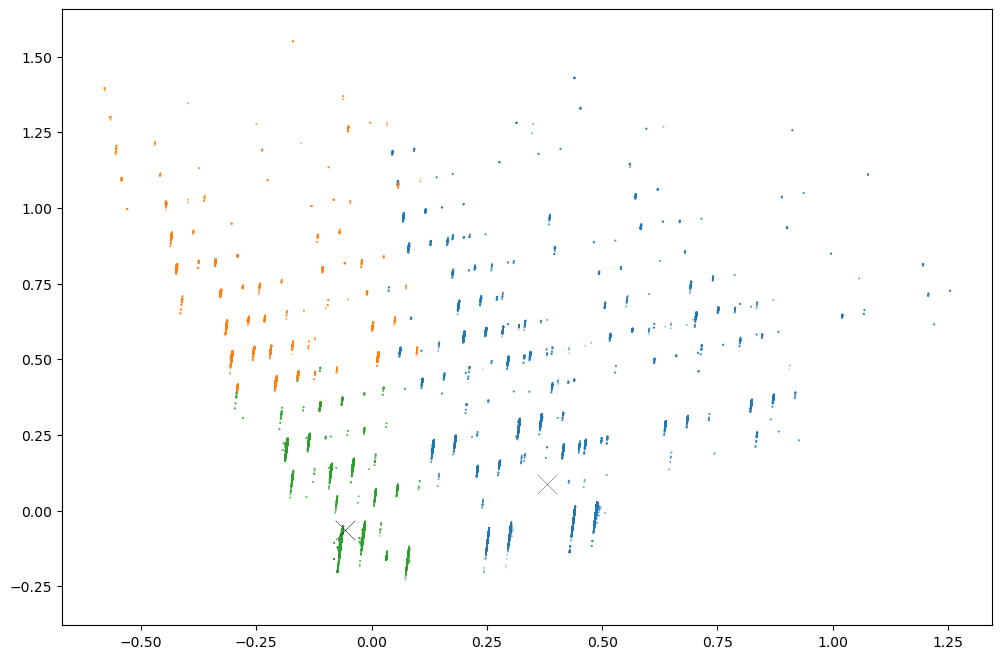

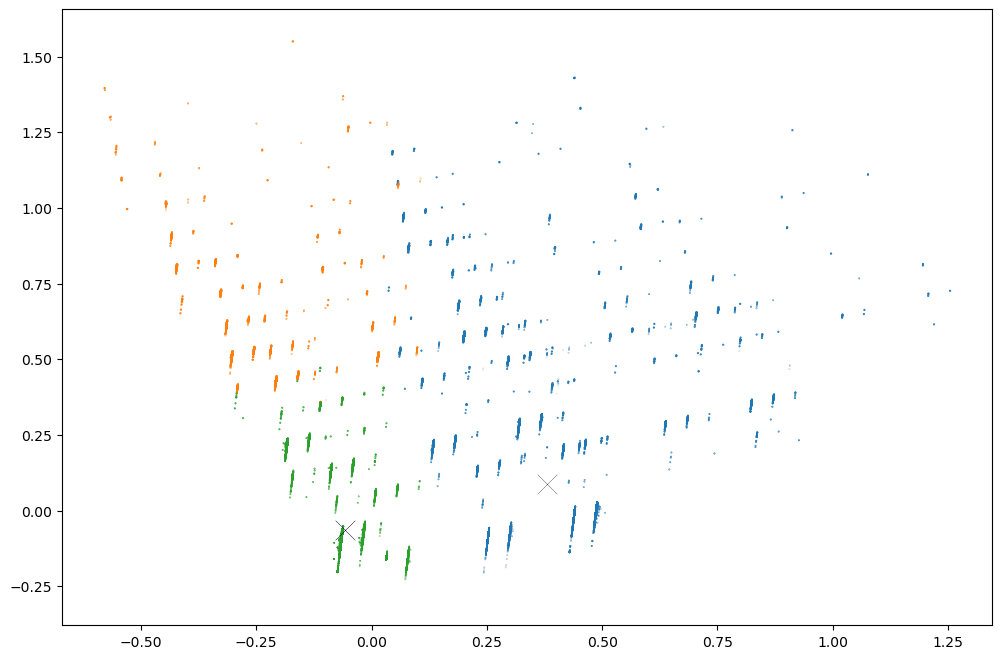

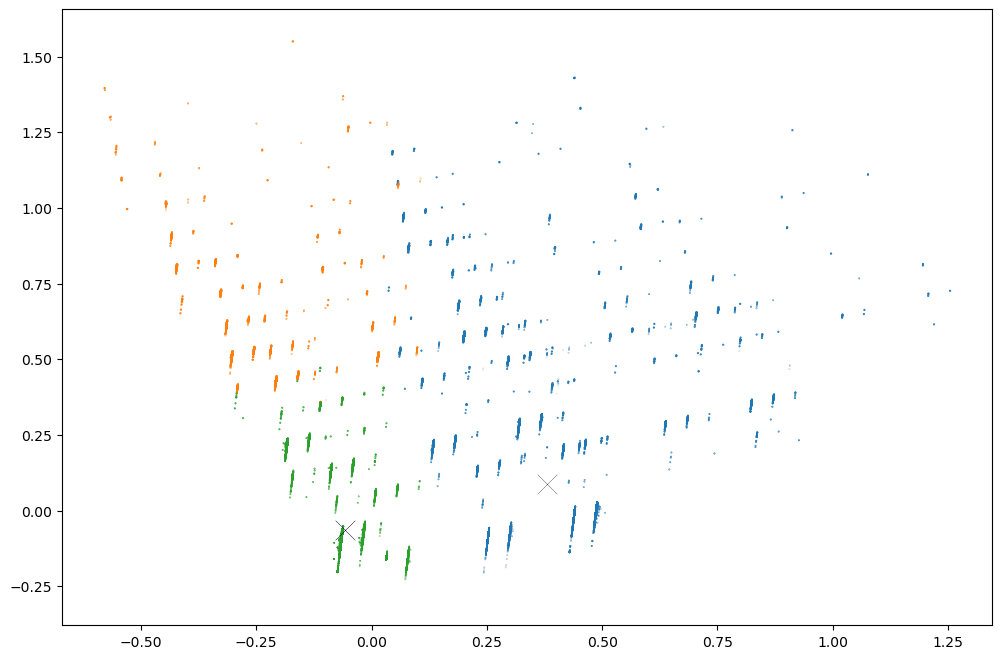

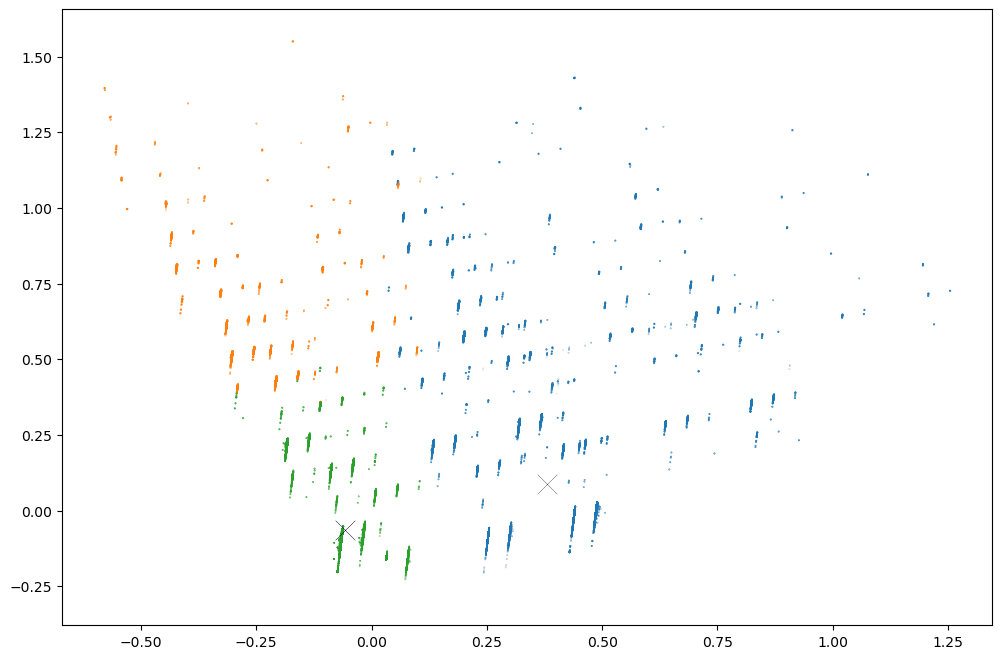

In [69]:
if __name__ == "__main__":
    
    clusters = 3
    print(clusters)
    k = KMeans(K=clusters, max_iters=150, plot_steps=True)
    y_pred = k.predict(pca_features)
    